In [1]:
from modules import datasets
from modules import models

from keras.backend import set_epsilon
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import argparse
import locale
import os
import tensorflow as tf

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", type=str, required=True,
#    help="path to input dataset of house images")
#args = vars(ap.parse_args())

##SAG3.csv has 10000 samples and no galaxies with 0 mass
##SAG4.csv has 10000 samples and no restrictions on mass
##SAG5.csv has 15000 samples and no restrictions on mass
##SAG6.csv has 10000 samples and masses over 10e+7 solar masses
inputPath = 'SAG3.csv'


# construct the path to the input .txt file that contains information
# on each house in the dataset and then load the dataset
print("[INFO] loading halo attributes...")
#inputPath = os.path.sep.join([args["dataset"], "HousesInfo.txt"])
df = datasets.load_halo_attributes(inputPath)
 
# construct a training and testing split with 75% of the data used
# for training and the remaining 25% for evaluation
print("[INFO] constructing training/testing split...")
(train, test) = train_test_split(df, test_size=0.25, random_state=42)

[INFO] loading halo attributes...
[INFO] constructing training/testing split...


19.885


(array([1222.,  108.,   53.,   46.,   22.,   12.,   13.,   10.,   12.,
           5.]),
 array([1.00e+08, 1.09e+09, 2.08e+09, 3.07e+09, 4.06e+09, 5.05e+09,
        6.04e+09, 7.03e+09, 8.02e+09, 9.01e+09, 1.00e+10]),
 <a list of 10 Patch objects>)

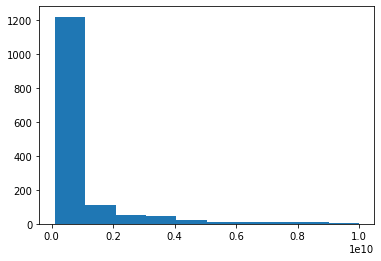

In [3]:
##replacing zeroes for very low masses so log10 doesn't fail
##trying with sum of masses

dummy_train = train['MstarDisk'] + train['MstarSpheroid']
#dummy_train = np.where(dummy_train==0, 1e-10, dummy_train)

dummy_test = test['MstarDisk'] + test['MstarSpheroid']
#dummy_test = np.where(dummy_test==0, 1e-10, dummy_test)
print(np.min(dummy_train))
plt.hist(dummy_train, range=[10e7, 10e9])


7500


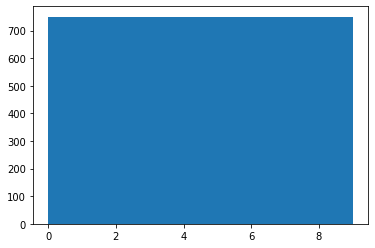

In [4]:
def log10bins(col, n=10):
    x=np.log10(np.array(col))
    bins = []
    percs = [-11]
    for i in range(n):
        percs.append(np.percentile(x, (i+1)*100/n))
    for item in x:

        for i in range(n):
            if item > percs[i] and item <= percs[i+1]:
                bins.append(i)

    return np.array(bins)


plt.hist(log10bins(dummy_train))    
train_Y = log10bins(dummy_train)
test_Y = log10bins(dummy_test)
print(len(train_Y))
#These 2 commented lines checked if the percentiles were distributed correctly
#unique, counts = np.unique(log10bins(test['MstarDisk']), return_counts=True)
#dict(zip(unique, counts))

In [5]:
from keras.utils.np_utils import to_categorical
trainY = to_categorical(train_Y, num_classes=None)
testY = to_categorical(test_Y, num_classes=None)

print (np.shape(trainY))


(7500, 10)


In [6]:

print("[INFO] processing data...")
(trainX, testX) = datasets.process_halo_attributes(df, train, test)

trainX = np.expand_dims(trainX, axis=2) ##Adding third dimension to input data so conv1D can be applied
testX = np.expand_dims(testX, axis=2)
print(np.shape(trainX))
print(np.shape(testX))

[INFO] processing data...
(7500, 4, 1)
(2500, 4, 1)


In [7]:
# create our MLP and then compile the model using mean absolute
# percentage error as our loss, implying that we seek to minimize
# the absolute percentage difference between our price *predictions*
# and the *actual prices*
model = models.create_cnn(trainX.shape[1])
opt = Adam(lr=1e-3, decay=1e-3 / 200)
set_epsilon(1)


  
    
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics = ['accuracy', tf.keras.metrics.Recall()])
 
# train the model
print("[INFO] training model...")
history = model.fit(trainX, trainY, validation_data=(testX, testY),
    epochs=200, batch_size=20)

print('model trained')

[INFO] training model...
Train on 7500 samples, validate on 2500 samples
Epoch 1/200
7500/7500 [==============================] - 2s 314us/step - loss: 2.2145 - accuracy: 0.1655 - recall: 0.0041 - val_loss: 2.1595 - val_accuracy: 0.1752 - val_recall: 0.0122
Epoch 2/200
7500/7500 [==============================] - 1s 168us/step - loss: 2.1309 - accuracy: 0.1859 - recall: 0.0159 - val_loss: 2.1410 - val_accuracy: 0.1760 - val_recall: 0.0182
Epoch 3/200
7500/7500 [==============================] - 1s 177us/step - loss: 2.1215 - accuracy: 0.1885 - recall: 0.0193 - val_loss: 2.1318 - val_accuracy: 0.1948 - val_recall: 0.0202
Epoch 4/200
7500/7500 [==============================] - 1s 170us/step - loss: 2.1135 - accuracy: 0.1931 - recall: 0.0208 - val_loss: 2.1289 - val_accuracy: 0.1988 - val_recall: 0.0215
Epoch 5/200
7500/7500 [==============================] - 1s 171us/step - loss: 2.1088 - accuracy: 0.2044 - recall: 0.0219 - val_loss: 2.1216 - val_accuracy: 0.1932 - val_recall: 0.0223
Ep

In [9]:
# make predictions on the testing data
print("[INFO] predicting galaxy star masses...")
preds = model.predict(testX)

# compute the difference between the *predicted* central galaxy star mass and the
# *actual* mass, then compute the percentage difference and
# the absolute percentage difference


diff = preds - testY
#percentDiff = (diff / testY) * 100
#absPercentDiff = np.abs(np.array(percentDiff))
 
# compute the mean and standard deviation of the absolute percentage
# difference
#mean = np.mean(absPercentDiff)
#std = np.std(absPercentDiff)
#print('done')

[INFO] predicting house prices...


In [10]:
diffs = []

for i in range(len(preds)):
    diffs.append(preds[i].argmax() - testY[i].argmax())
    #print ('%d, %d'%(preds[i].argmax(), testY[i].argmax()))
diffs= np.array(diffs)

print((len(diffs) - np.count_nonzero(diffs))/len(diffs))


0.4616


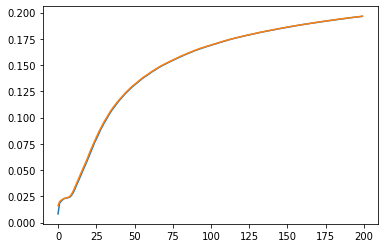

In [14]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.show()